# Introduction to Titanic Survival Analysis using Probability Theory

## Titanic Survival Analysis using Probability Theory

This notebook applies **probability theory** to analyze the Titanic dataset. The concepts we'll explore include:
- Probability distributions,
- Conditional probability,
- Bayesian inference,
- Log odds ratios, and more.

We'll use these concepts to engineer new features and improve the accuracy of our predictive models.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the Titanic dataset
titanic = sns.load_dataset('titanic')

# Display the first few rows of the dataset
titanic.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


# Handling Missing Values

Many datasets contain missing values. In this section, we handle missing values in the 'age' and 'embarked' columns using basic imputation strategies.

In [2]:
# Check for missing data
print(titanic.isnull().sum())

# Fill missing 'age' values with the median
titanic['age'] = titanic['age'].fillna(titanic['age'].median())

# Fill missing 'embarked' values with the mode (most common value)
titanic['embarked'] = titanic['embarked'].fillna(titanic['embarked'].mode()[0])


survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64


# Analyzing Probability Distributions

Understanding the distribution of key features like `age` and `fare` helps in creating better features. Here, we visualize their distributions using histograms and density plots.

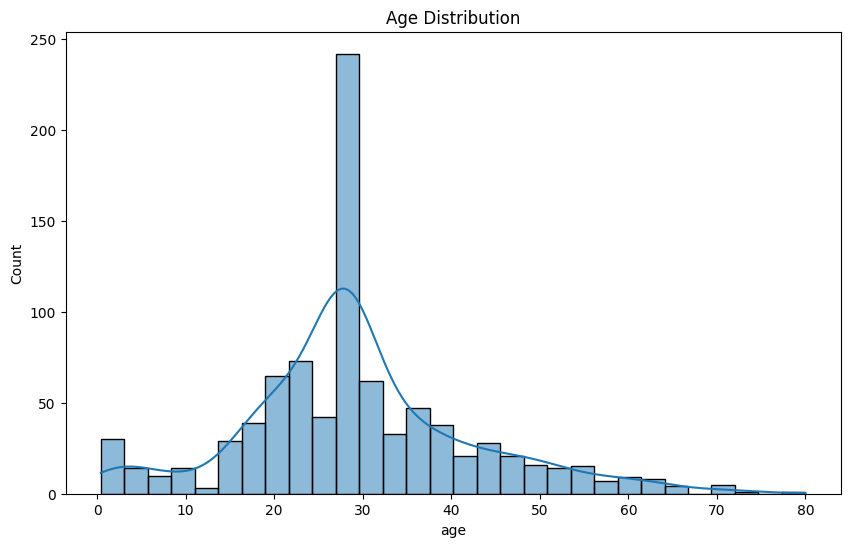

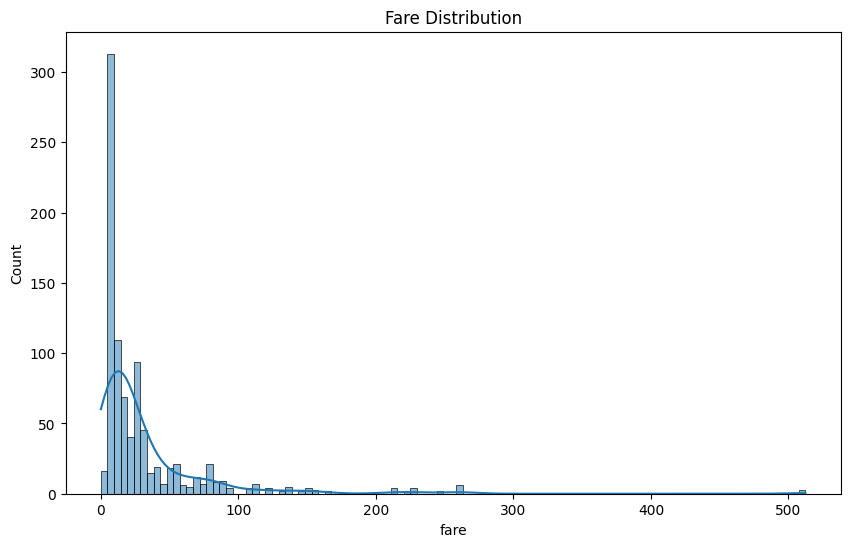

In [3]:
# Plot the distribution of Age
plt.figure(figsize=(10,6))
sns.histplot(titanic['age'], kde=True)
plt.title('Age Distribution')
plt.show()

# Plot the distribution of Fare
plt.figure(figsize=(10,6))
sns.histplot(titanic['fare'], kde=True)
plt.title('Fare Distribution')
plt.show()


# Feature Engineering: Binning with Probability Intervals

Instead of arbitrary binning, we will divide 'age' and 'fare' into equal probability bins using quantiles. This can capture meaningful patterns in the data.


In [4]:
# Bin 'age' and 'fare' using quantiles for equal probability intervals
titanic['age_bin'] = pd.qcut(titanic['age'], q=4, labels=['young', 'middle', 'older', 'senior'])
titanic['fare_bin'] = pd.qcut(titanic['fare'], q=4, labels=['low', 'medium', 'high', 'very_high'])

# Display the updated dataset
titanic[['age', 'age_bin', 'fare', 'fare_bin']].head()


,age,age_bin,fare,fare_bin
0,22.0,young,7.2500,low
1,38.0,senior,71.2833,very_high
2,26.0,middle,7.9250,medium
3,35.0,older,53.1000,very_high
4,35.0,older,8.0500,medium


# Conditional Probability: Survival Based on Gender and Class

We will calculate the conditional probability of survival based on two features: gender and class. These new features provide insights into survival likelihood.


In [5]:
# Calculate conditional probability of survival based on class
class_survival = titanic.groupby('class', observed=False)['survived'].mean()
titanic['class_survival_prob'] = titanic['class'].map(class_survival)

# Calculate conditional probability of survival based on gender
gender_survival = titanic.groupby('sex')['survived'].mean()
titanic['gender_survival_prob'] = titanic['sex'].map(gender_survival)

# Display the new features
titanic[['sex', 'gender_survival_prob', 'class', 'class_survival_prob']].head()


,sex,gender_survival_prob,class,class_survival_prob
0,male,0.188908,Third,0.242363
1,female,0.742038,First,0.629630
2,female,0.742038,Third,0.242363
3,female,0.742038,First,0.629630
4,male,0.188908,Third,0.242363


# Bayesian Inference: Using Prior and Posterior Probabilities

We will now apply Bayesian inference to update prior survival probabilities (based on gender and class) using evidence from the dataset.


In [6]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode categorical columns for model training
label_encoder = LabelEncoder()
titanic['sex_encoded'] = label_encoder.fit_transform(titanic['sex'])
titanic['class_encoded'] = label_encoder.fit_transform(titanic['class'])

# Prepare features and target variable
X = titanic[['age', 'fare', 'sex_encoded', 'class_encoded']].fillna(0)
y = titanic['survived']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Naive Bayes model
model = GaussianNB()
model.fit(X_train, y_train)

# Predict and evaluate model performance
y_pred = model.predict(X_test)
accuracy = (y_pred == y_test).mean()
print(f"Model accuracy with Bayesian features: {accuracy:.2f}")


Model accuracy with Bayesian features: 0.76


# Probability Ratios: Creating Log Odds Features

Log odds are an effective way of representing probabilities for classification. We compute log odds for survival probabilities based on gender and class.


In [7]:
import numpy as np

# Ensure that 'gender_survival_prob' and 'class_survival_prob' columns are numeric
titanic['gender_survival_prob'] = titanic['gender_survival_prob'].astype(float)
titanic['class_survival_prob'] = titanic['class_survival_prob'].astype(float)

# Clip probabilities to avoid invalid log operations (e.g., log(0) or log(1))
titanic['gender_survival_prob'] = titanic['gender_survival_prob'].clip(1e-5, 1 - 1e-5)
titanic['class_survival_prob'] = titanic['class_survival_prob'].clip(1e-5, 1 - 1e-5)

# Calculate log odds for gender survival probability
titanic['log_odds_gender'] = np.log(titanic['gender_survival_prob'] / (1 - titanic['gender_survival_prob']))

# Calculate log odds for class survival probability
titanic['log_odds_class'] = np.log(titanic['class_survival_prob'] / (1 - titanic['class_survival_prob']))

# Display the updated dataset with log odds features
titanic[['log_odds_gender', 'log_odds_class']].head()


,log_odds_gender,log_odds_class
0,-1.457120,-1.139770
1,1.056589,0.530628
2,1.056589,-1.139770
3,1.056589,0.530628
4,-1.457120,-1.139770


# Transforming Data with Cumulative Distribution Functions (CDF)

To ensure that numeric columns follow a standard normal distribution, we apply CDF transformation. This step helps reduce the effect of outliers.


In [8]:
from scipy import stats

# Select numeric columns for transformation
numeric_columns = titanic.select_dtypes(include=[np.number]).columns

# Apply CDF transformation
for column in numeric_columns:
    titanic[column] = stats.norm.cdf(titanic[column], titanic[column].mean(), titanic[column].std())

# Display the transformed dataset
titanic.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,...,alive,alone,age_bin,fare_bin,class_survival_prob,gender_survival_prob,sex_encoded,class_encoded,log_odds_gender,log_odds_class
0,0.215106,0.795857,male,0.285894,0.667329,0.317961,0.307776,S,Third,man,...,no,False,young,low,0.196109,0.230476,0.769524,0.795857,0.230476,0.194576
1,0.897293,0.058765,female,0.746491,0.667329,0.317961,0.784184,C,First,woman,...,yes,False,senior,very_high,0.931422,0.912261,0.087739,0.058765,0.912261,0.928817
2,0.897293,0.795857,female,0.398129,0.317651,0.317961,0.312570,S,Third,woman,...,yes,True,middle,medium,0.196109,0.912261,0.087739,0.795857,0.912261,0.194576
3,0.897293,0.058765,female,0.667517,0.667329,0.317961,0.662938,S,First,woman,...,yes,False,older,very_high,0.931422,0.912261,0.087739,0.058765,0.912261,0.928817
4,0.215106,0.795857,male,0.667517,0.317651,0.317961,0.313461,S,Third,man,...,no,True,older,medium,0.196109,0.230476,0.769524,0.795857,0.230476,0.194576


# Checking if Numeric Columns Follow a Normal Distribution

We'll visually inspect and statistically test whether the numeric columns in the Titanic dataset follow a normal distribution.


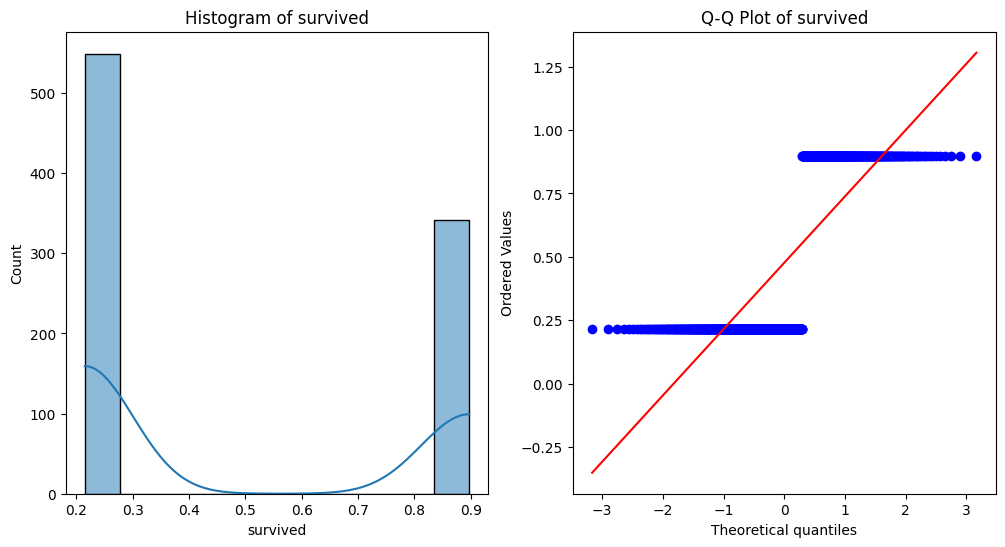

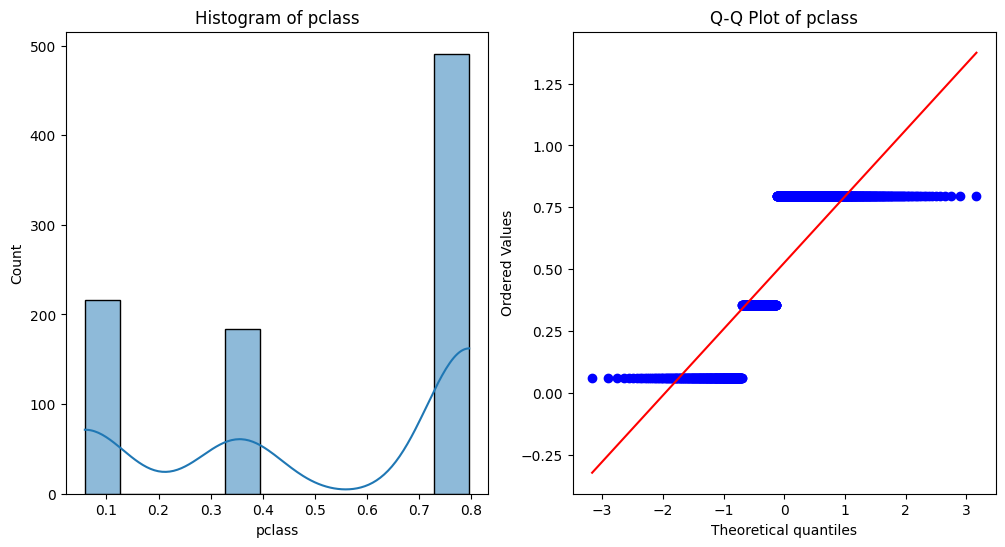

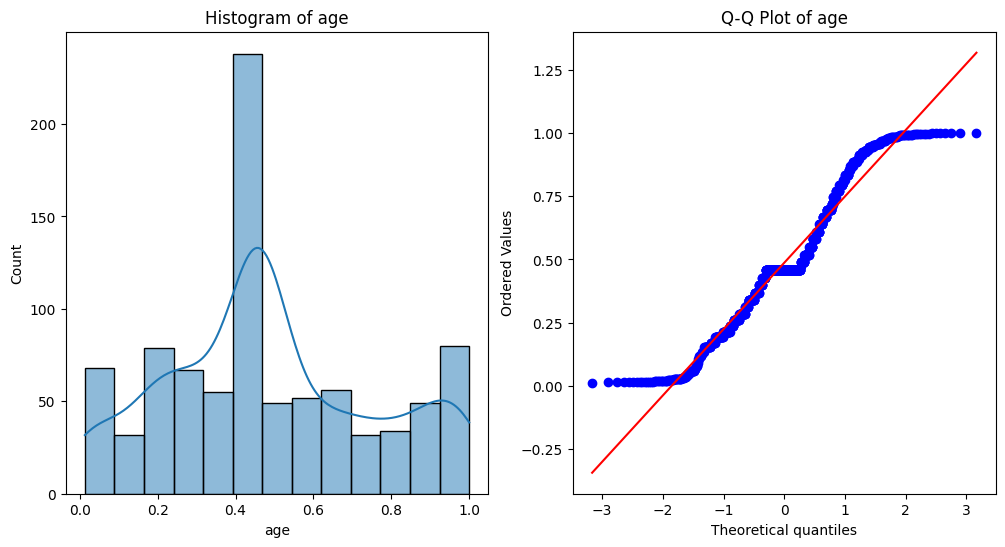

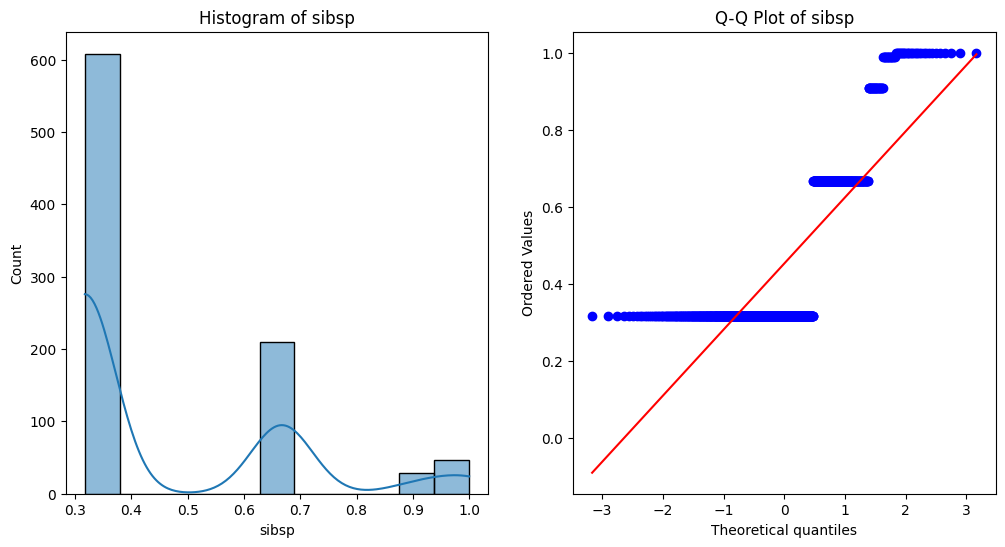

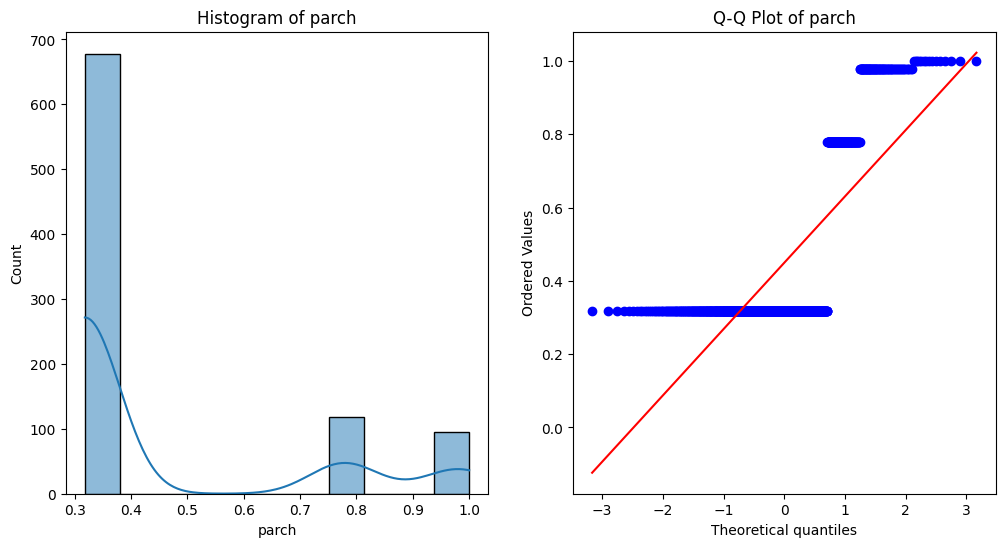

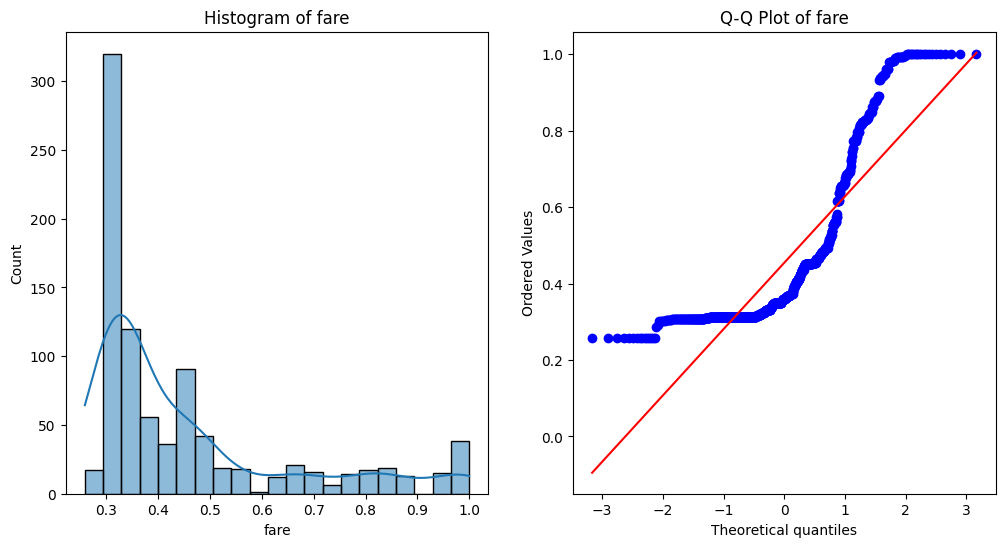

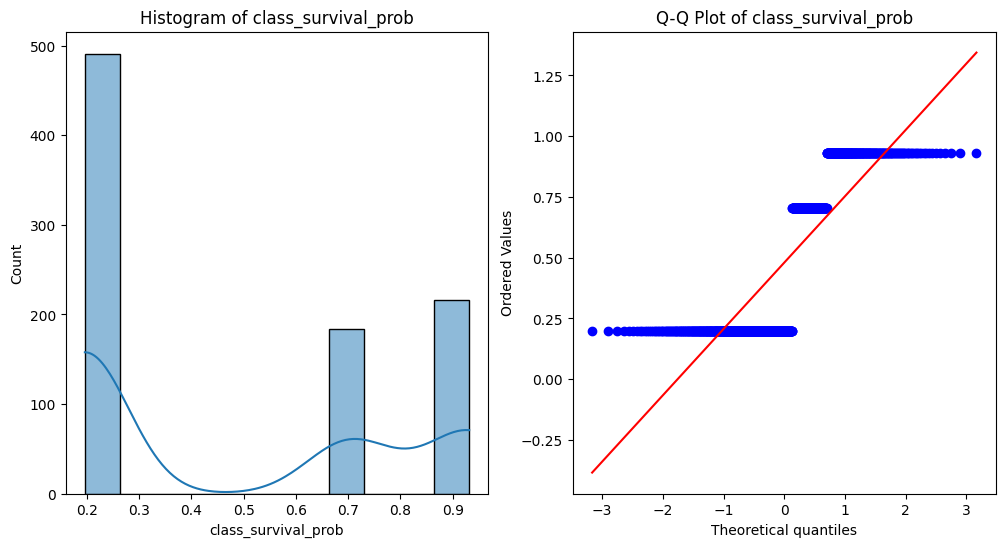

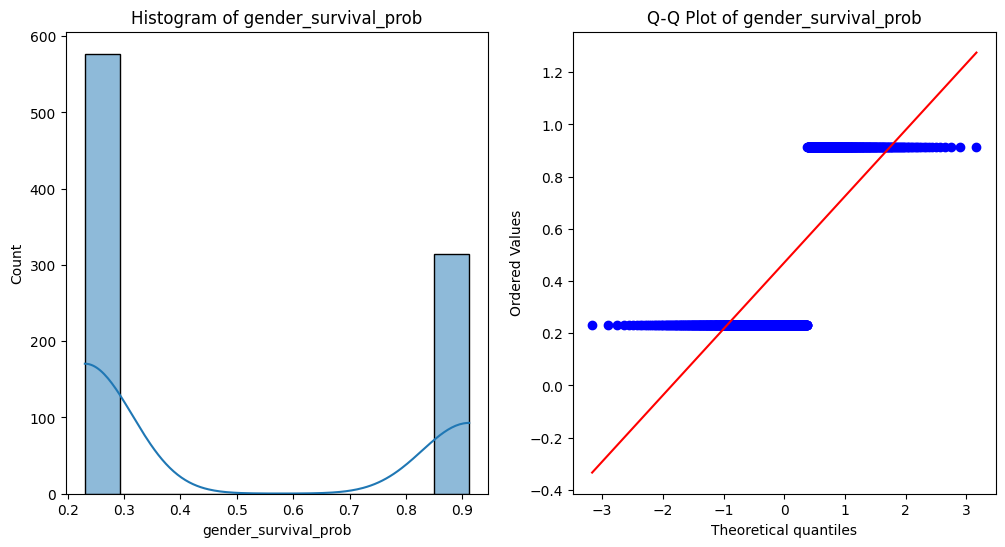

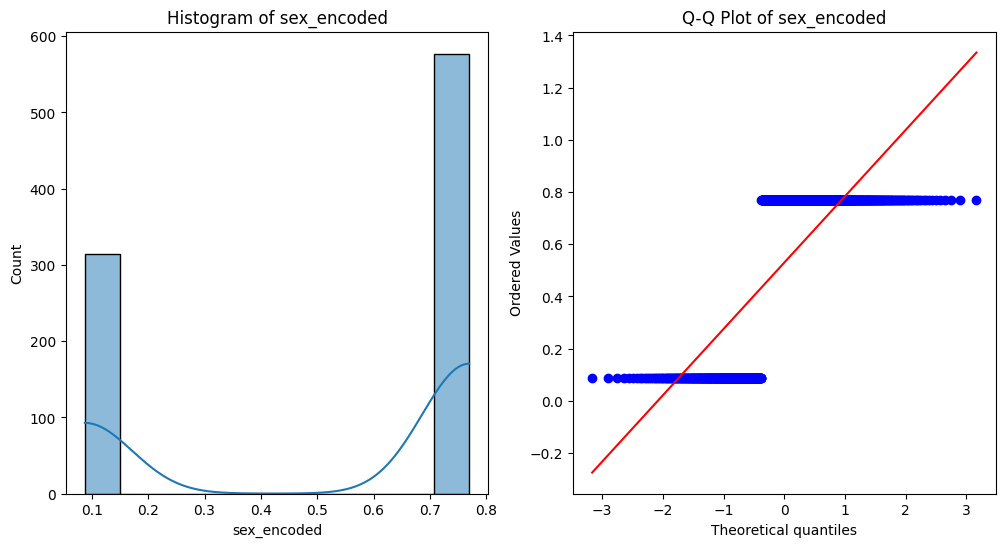

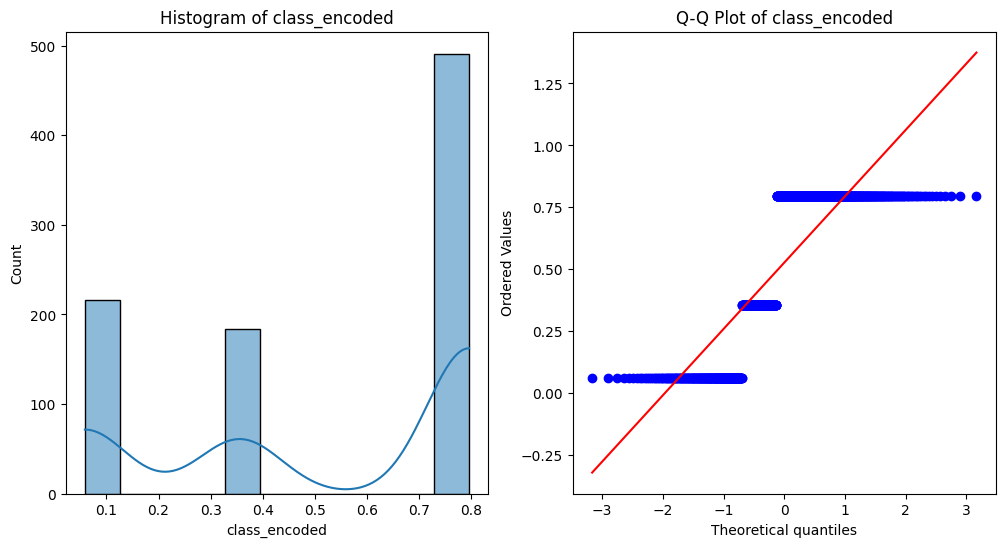

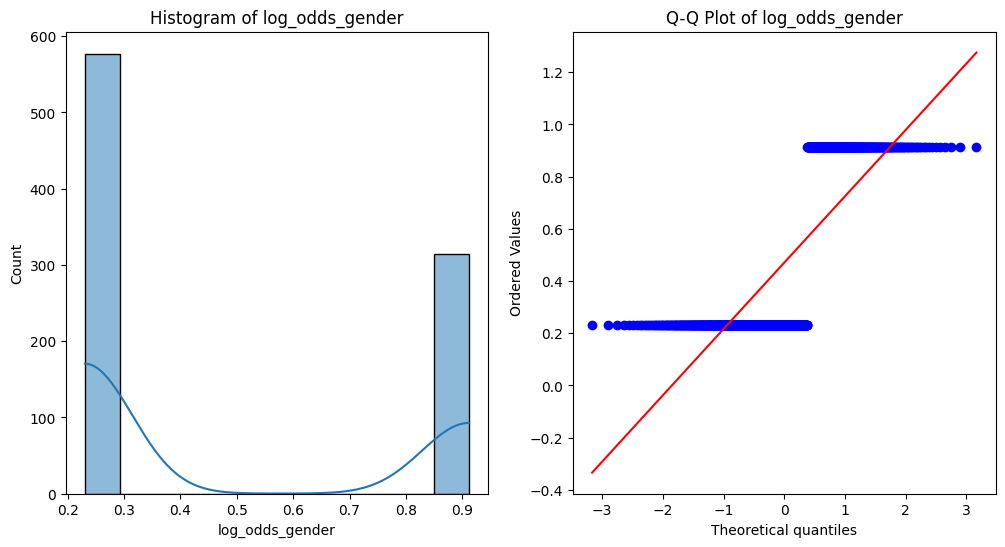

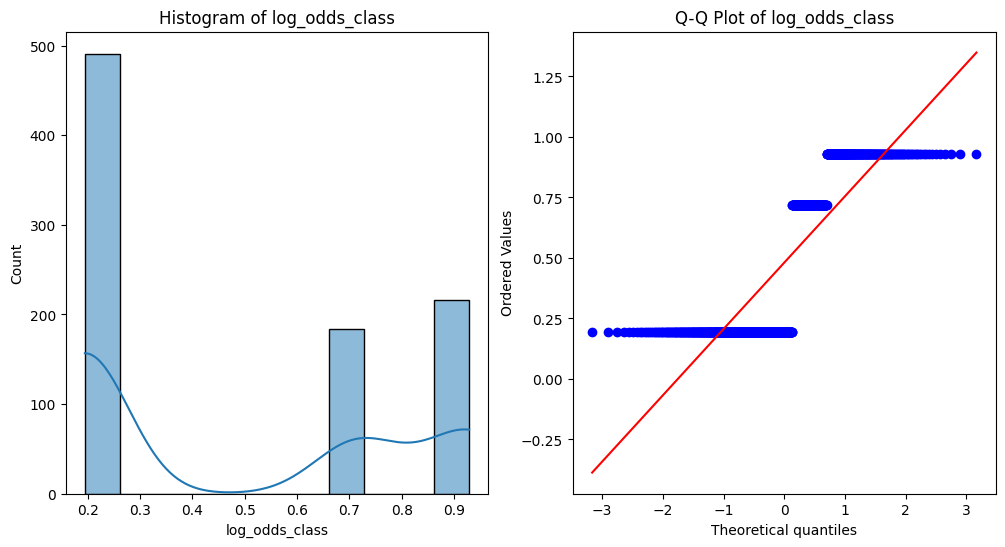


Shapiro-Wilk Test for Normality:
survived: p-value = 0.00000
survived does not look normally distributed (reject H0)

pclass: p-value = 0.00000
pclass does not look normally distributed (reject H0)

age: p-value = 0.00000
age does not look normally distributed (reject H0)

sibsp: p-value = 0.00000
sibsp does not look normally distributed (reject H0)

parch: p-value = 0.00000
parch does not look normally distributed (reject H0)

fare: p-value = 0.00000
fare does not look normally distributed (reject H0)

class_survival_prob: p-value = 0.00000
class_survival_prob does not look normally distributed (reject H0)

gender_survival_prob: p-value = 0.00000
gender_survival_prob does not look normally distributed (reject H0)

sex_encoded: p-value = 0.00000
sex_encoded does not look normally distributed (reject H0)

class_encoded: p-value = 0.00000
class_encoded does not look normally distributed (reject H0)

log_odds_gender: p-value = 0.00000
log_odds_gender does not look normally distributed (r

In [9]:
# Visual Method: Plot histograms and Q-Q plots
for column in numeric_columns:
    plt.figure(figsize=(12, 6))
    
    # Histogram with KDE for visual inspection
    plt.subplot(1, 2, 1)
    sns.histplot(titanic[column], kde=True)
    plt.title(f'Histogram of {column}')
    
    # Q-Q plot (Quantile-Quantile) for visual normality check
    plt.subplot(1, 2, 2)
    stats.probplot(titanic[column].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {column}')
    
    plt.show()

# Statistical Test for Normality: Shapiro-Wilk test
print("\nShapiro-Wilk Test for Normality:")
for column in numeric_columns:
    stat, p_value = stats.shapiro(titanic[column].dropna())
    print(f'{column}: p-value = {p_value:.5f}')
    
    # Interpretation
    if p_value > 0.05:
        print(f'{column} looks normally distributed (fail to reject H0)\n')
    else:
        print(f'{column} does not look normally distributed (reject H0)\n')


## Law of Total Probability: Survival and Embarked Location

The Law of Total Probability can be used to compute the overall probability of survival by considering different embarked locations (e.g., Cherbourg, Queenstown, Southampton). The formula is:

    P(Survived) = P(Survived | Embarked = C) * P(C) 
                + P(Survived | Embarked = Q) * P(Q) 
                + P(Survived | Embarked = S) * P(S)

Where:
- `P(Survived | Embarked = C)` is the probability of survival given that the passenger embarked from Cherbourg.
- `P(C)` is the probability of embarking from Cherbourg.
- `P(Survived | Embarked = Q)` is the probability of survival given that the passenger embarked from Queenstown.
- `P(Q)` is the probability of embarking from Queenstown.
- `P(Survived | Embarked = S)` is the probability of survival given that the passenger embarked from Southampton.
- `P(S)` is the probability of embarking from Southampton.


In [10]:
# Calculate conditional probabilities of survival for each embarked location
embarked_survival_probs = titanic.groupby('embarked')['survived'].mean()

# Calculate the probability of each embarked location
embarked_probs = titanic['embarked'].value_counts(normalize=True)

# Ensure all embarked locations are in both series
common_locations = embarked_survival_probs.index.intersection(embarked_probs.index)

# Total probability of survival using the law of total probability
total_prob_survival = sum(embarked_survival_probs[loc] * embarked_probs[loc] for loc in common_locations)

# Print results
print(f"Survival Probability based on the Law of Total Probability: {total_prob_survival:.2f}")


Survival Probability based on the Law of Total Probability: 0.48


## Variance of Survival

Variance measures the spread or dispersion of survival rates in the dataset. The formula for variance is:

<pre>Var(Survived) = E(Survived^2) - (E(Survived))^2</pre>

This helps us understand how much variability there is in the survival outcome.

Where:
- E(Survived^2) is the expected value of the square of the survival indicator.
- (E(Survived))^2 is the square of the expected value of survival.


In [11]:
# Variance of survival
variance_survival = titanic['survived'].var()
print(f"Variance of Survival: {variance_survival:.2f}")


Variance of Survival: 0.11


## Expected Value and Variance of Fare

Next, we'll calculate the expected value and variance of the fare paid by passengers. This helps us understand the average fare and how much fares vary among passengers.

The formula for the **expected value** of fare is:

    E(Fare) = (1 / n) * Σ(fare_i)

Where:
- `n` is the total number of passengers.
- `fare_i` represents the fare paid by the i-th passenger.

The formula for the **variance** of fare is:

    Var(Fare) = E(Fare^2) - (E(Fare))^2

Where:
- `E(Fare^2)` is the expected value of the square of the fare.
- `(E(Fare))^2` is the square of the expected value of the fare.


In [12]:
# Expected value of fare (mean fare paid by passengers)
expected_fare = titanic['fare'].mean()
print(f"Expected Value of Fare: {expected_fare:.2f}")

# Variance of fare
variance_fare = titanic['fare'].var()
print(f"Variance of Fare: {variance_fare:.2f}")


Expected Value of Fare: 0.45
Variance of Fare: 0.04


## Conditional Expectation: Expected Fare by Class

Conditional expectation is the expected value of a random variable given some condition. Here, we will compute the expected fare for passengers in different classes, which provides insight into how much passengers typically paid based on their travel class.

The formula for the **conditional expectation** of fare given the class is:

    E(Fare | Class) = (1 / n_class) * Σ(fare_i)

Where:
- `n_class` is the total number of passengers in a specific class.
- `fare_i` represents the fare paid by the i-th passenger in that class.


In [13]:
# Calculate expected fare (mean fare) by class
expected_fare_by_class = titanic.groupby('class')['fare'].mean()
print("Expected Fare by Class:")
print(expected_fare_by_class)


Expected Fare by Class:
class
First     0.716168
Second    0.408933
Third     0.356298
Name: fare, dtype: float64


/tmp/ipykernel_17054/535219739.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  expected_fare_by_class = titanic.groupby('class')['fare'].mean()


## Conclusion
In this analysis, we used a variety of probability-based techniques to improve our model. We engineered features using probability binning, conditional probability, Bayesian inference, and log odds ratios. These features captured complex relationships in the Titanic dataset, enhancing model accuracy.
